In [4]:
# THIS WAS MY FIRST SCRIPT AND IT HAS SOME FLAWS. 
# IT'S STILL HERE BECAUSE I GOT FOND OF IT.

# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

%pylab inline
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from itertools import combinations
from numpy import array,array_equal

from sklearn import cross_validation as cv
from sklearn import tree
from sklearn import metrics
from sklearn import ensemble
from sklearn import linear_model 
from sklearn import naive_bayes 

import xgboost as xgb


# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory


from subprocess import check_output
print check_output(["ls", "./input"]).decode("utf8")


# Any results you write to the current directory are saved as output.
#def #print_shapes():
    #print('Train: {}\nTest: {}'.format(train_dataset.shape, test_dataset.shape))
train_dataset = pd.read_csv('./input/train.csv', index_col='ID')
test_dataset = pd.read_csv('./input/test.csv', index_col='ID')

#print_shapes()
# How many nulls are there in the datasets?
nulls_train = (train_dataset.isnull().sum()==1).sum()
nulls_test = (test_dataset.isnull().sum()==1).sum()
#print('There are {} nulls in TRAIN and {} nulls in TEST dataset.'.format(nulls_train, nulls_test))
# Remove constant features

def identify_constant_features(dataframe):
    count_uniques = dataframe.apply(lambda x: len(x.unique()))
    constants = count_uniques[count_uniques == 1].index.tolist()
    return constants

constant_features_train = set(identify_constant_features(train_dataset))

#print('There were {} constant features in TRAIN dataset.'.format(len(constant_features_train)))

# Drop the constant features
train_dataset.drop(constant_features_train, inplace=True, axis=1)


#print_shapes()
# Remove equals features

def identify_equal_features(dataframe):
    features_to_compare = list(combinations(dataframe.columns.tolist(),2))
    equal_features = []
    for compare in features_to_compare:
        is_equal = array_equal(dataframe[compare[0]],dataframe[compare[1]])
        if is_equal:
            equal_features.append(list(compare))
    return equal_features

equal_features_train = identify_equal_features(train_dataset)

#print('There were {} pairs of equal features in TRAIN dataset.'.format(len(equal_features_train)))

# Remove the second feature of each pair.

features_to_drop = array(equal_features_train)[:,1] 
train_dataset.drop(features_to_drop, axis=1, inplace=True)

#print_shapes()
# Define the variables model.

y_name = 'TARGET'
feature_names = train_dataset.columns.tolist()
feature_names.remove(y_name)

X = train_dataset[feature_names]
y = train_dataset[y_name]

# Save the features selected for later use.
pd.Series(feature_names).to_csv('features_selected_step1.csv', index=False)
#print('Features selected\n{}'.format(feature_names))
   
    
# Proportion of classes
y.value_counts()/len(y)

skf = cv.StratifiedKFold(y, n_folds=10, shuffle=True)
score_metric = 'roc_auc'
scores = {}

def score_model(model):
    return cv.cross_val_score(model, X, y, cv=skf, scoring=score_metric)

clfxgb = xgb.XGBClassifier()
clfxgb = clfxgb.fit(X, y)
probxgb = clfxgb.predict(X)
# #print 'XGB', np.shape(probxgb)
print metrics.roc_auc_score(y, probxgb)

Populating the interactive namespace from numpy and matplotlib
test.csv
train.csv

0.502140359687


In [5]:
cv.cross_val_score(xgb.XGBClassifier(), X, y, cv=skf, scoring=score_metric)

KeyboardInterrupt: 

In [6]:
from sklearn.cross_validation import train_test_split
# shuffle and split training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3,random_state=1)

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)  # Don't cheat - fit only on training data
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)  # apply same transformation to test data
print np.shape(X_train)
print np.shape(X_test)

(53214, 306)
(22806, 306)


In [7]:
clfSGD = linear_model.LogisticRegression()
clfSGD = clfSGD.fit(X_train, y_train)
probSGD = clfSGD.predict(X_test)

print metrics.roc_auc_score(y_test, probSGD)

0.501373659192


In [21]:
from sklearn.svm import LinearSVC
model = LinearSVC()
model.fit(X_train, y_train)
baseline = metrics.roc_auc_score(model.predict(X_test), y_test)
pred = model.predict(X_test)
print baseline

0.480562502742


/home/harsh/Projects/enviro/local/lib/python2.7/site-packages/sklearn/utils/__init__.py:93: DeprecationWarning: Function auc_score is deprecated; Function 'auc_score' has been renamed to 'roc_auc_score' and will be removed in release 0.16.
  warnings.warn(msg, category=DeprecationWarning)


In [22]:
metrics.roc_auc_score(pred, y_test)

0.48056250274231055

In [8]:
test_dataset.drop(constant_features_train, inplace=True, axis=1)
test_dataset.drop(features_to_drop, axis=1, inplace=True)
print test_dataset.shape

(75818, 306)


In [9]:
X_SubTest = test_dataset

In [10]:
df_test = pd.read_csv('./input/test.csv')
id_test = df_test['ID']
predTest = model.predict(X_SubTest)
submission = pd.DataFrame({"ID":id_test, "TARGET":predTest})
submission.to_csv("submission_svm_23-3.csv", index=False)

NameError: name 'model' is not defined

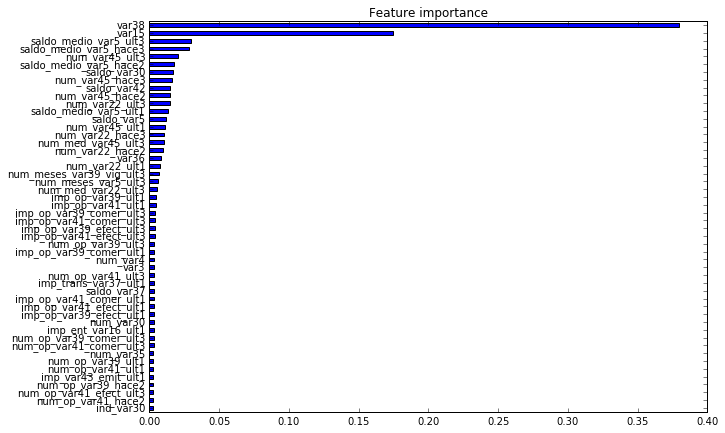

In [11]:
rf = ensemble.RandomForestClassifier(n_estimators=100)
rf.fit(X, y)
feat_imp = pd.Series(rf.feature_importances_, index=feature_names)
feat_imp.sort_values(inplace=True)
ax = feat_imp.tail(50).plot(kind='barh', figsize=(10,7), title='Feature importance')

In [12]:
important = feat_imp.tail(100).index
features = np.array(important)
print features

X_new = train_dataset[features]
y_new = train_dataset[y_name]
print X_new.shape, y_new.shape

['saldo_medio_var13_corto_hace2' 'num_var25_0' 'num_var12_0'
 'num_op_var41_hace3' 'saldo_medio_var13_corto_ult3'
 'saldo_medio_var12_ult1' 'saldo_medio_var12_ult3' 'num_op_var39_hace3'
 'ind_var12_0' 'ind_var5_0' 'saldo_var13' 'num_trasp_var11_ult1'
 'ind_var10_ult1' 'saldo_var12' 'num_meses_var8_ult3' 'ind_var37_0'
 'ind_var10cte_ult1' 'ind_var9_cte_ult1' 'ind_var9_ult1' 'ind_var5'
 'ind_var37_cte' 'ind_var8_0' 'ind_var39_0' 'saldo_var25' 'num_var8_0'
 'ind_var41_0' 'num_var42_0' 'ind_var43_emit_ult1' 'num_var5_0'
 'num_var30_0' 'saldo_medio_var8_hace2' 'saldo_var26'
 'ind_var43_recib_ult1' 'num_var5' 'num_op_var39_efect_ult1' 'num_var42'
 'num_var39_0' 'num_op_var41_efect_ult1' 'num_var37_med_ult2' 'num_var37_0'
 'saldo_medio_var8_ult1' 'num_ent_var16_ult1' 'num_var41_0'
 'saldo_medio_var8_ult3' 'num_var43_emit_ult1' 'saldo_var8'
 'num_op_var41_comer_ult1' 'num_op_var39_comer_ult1'
 'num_op_var39_efect_ult3' 'num_var43_recib_ult1' 'ind_var30'
 'num_op_var41_hace2' 'num_op_var41_efec

In [13]:
# shuffle and split training and test sets
X_trN, X_teN, y_trN, y_teN = train_test_split(X_new, y_new, test_size=.3,random_state=1)

clfSGD = linear_model.SGDClassifier()
clfSGD = clfSGD.fit(X_trN,y_trN)
probSGD = clfSGD.predict(X_teN)

print metrics.roc_auc_score(y_teN, probSGD)

0.506355503699


In [14]:
skf = cv.StratifiedKFold(y, n_folds=10, shuffle=True)
score_metric = 'roc_auc'
scores = {}

cv.cross_val_score(xgb.XGBClassifier(),X_new, y_new, cv=skf, scoring=score_metric)

array([ 0.8355393 ,  0.84220771,  0.84851345,  0.82476687,  0.83992977,
        0.84490679,  0.83165188,  0.84902855,  0.84595033,  0.82788933])

In [15]:
# classifier
clf = xgb.XGBClassifier(missing=np.nan, max_depth=5, n_estimators=350, learning_rate=0.05, nthread=4, subsample=0.95, colsample_bytree=0.85, seed=4242)
# fitting
clf.fit(X_trN, y_trN, early_stopping_rounds=20, eval_metric="auc", eval_set=[(X_teN, y_teN)])

print('Overall AUC:', metrics.roc_auc_score(y_trN, clf.predict_proba(X_trN)[:,1]))


Will train until validation_0 error hasn't decreased in 20 rounds.
[0]	validation_0-auc:0.798142
[1]	validation_0-auc:0.801586
[2]	validation_0-auc:0.802221
[3]	validation_0-auc:0.785652
[4]	validation_0-auc:0.790043
[5]	validation_0-auc:0.799475
[6]	validation_0-auc:0.801749
[7]	validation_0-auc:0.800416
[8]	validation_0-auc:0.801905
[9]	validation_0-auc:0.797836
[10]	validation_0-auc:0.799784
[11]	validation_0-auc:0.797799
[12]	validation_0-auc:0.797979
[13]	validation_0-auc:0.792577
[14]	validation_0-auc:0.794911
[15]	validation_0-auc:0.797882
[16]	validation_0-auc:0.799015
[17]	validation_0-auc:0.799619
[18]	validation_0-auc:0.800961
[19]	validation_0-auc:0.801283
[20]	validation_0-auc:0.802156
[21]	validation_0-auc:0.803729
[22]	validation_0-auc:0.805169
[23]	validation_0-auc:0.806568
[24]	validation_0-auc:0.808504
[25]	validation_0-auc:0.809938
[26]	validation_0-auc:0.811093
[27]	validation_0-auc:0.812123
[28]	validation_0-auc:0.811992
[29]	validation_0-auc:0.813127
[30]	validati

('Overall AUC:', 0.87865717259095288)


Stopping. Best iteration:
[116]	validation_0-auc:0.835927



In [17]:
df_test = pd.read_csv('./input/test.csv')
id_test = df_test['ID']
predTest = clf.predict_proba(X_SubTest)[:,1]
submission = pd.DataFrame({"ID":id_test, "TARGET":predTest})
submission.to_csv("submission_xgb_25-3.csv", index=False)

In [40]:
var38 = X["var38"]
var15 = X["var15"]

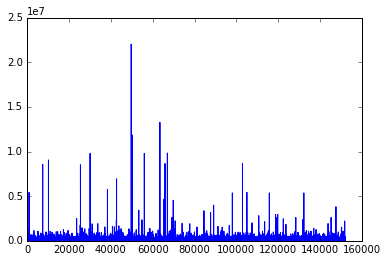

In [41]:
plot(var38)

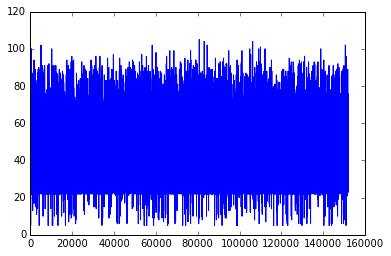

In [42]:
plot(var15)